# Scenario Testing

* A set of scenarios with extreme parameters is created to test model outputs
* Varying the ranges of beds, all other parameters unchanged
* Varying the sd  los on revision patients only, all other parameters unchanged
* Varying the mean los on revision patients only, all other parameters unchanged
* Varying the mean los on all procedures, all other parameters unchanged


## 1. MODEL TEST RUNS: Extreme Scenarios:

In [2]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools
import textwrap
import model2 as md

In [3]:
def get_scenarios():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Used for testing extreme scenarios
    
    Returns:
    --------
    dict
        Contains stress tests for the model
    '''
    scenarios = {}
    schedule = md.Schedule()
    scenarios['base'] = md.Scenario(schedule)
    
    # define scenarios
    scenarios['beds-20'] = md.Scenario(schedule, n_beds=scenarios['base'].n_beds-20)
    scenarios['beds+20'] = md.Scenario(schedule, n_beds=scenarios['base'].n_beds+20)
    
    reduction = 2 
    primary_hip_mean_los = scenarios['base'].primary_hip_mean_los - reduction
    revision_hip_mean_los = scenarios['base'].revision_hip_mean_los - reduction
    revision_knee_mean_los = scenarios['base'].revision_knee_mean_los - reduction
    primary_knee_mean_los = scenarios['base'].primary_knee_mean_los - reduction
    unicompart_knee_mean_los = scenarios['base'].unicompart_knee_mean_los - reduction
    scenarios[f'los-{reduction}'] = md.Scenario(schedule,primary_hip_mean_los=primary_hip_mean_los,
                                            revision_hip_mean_los=revision_hip_mean_los,
                                            revision_knee_mean_los=revision_knee_mean_los,
                                            primary_knee_mean_los=primary_knee_mean_los,
                                            unicompart_knee_mean_los=unicompart_knee_mean_los)
    
    increase = 20 
    primary_hip_mean_los = scenarios['base'].primary_hip_mean_los + increase
    revision_hip_mean_los = scenarios['base'].revision_hip_mean_los + increase
    revision_knee_mean_los = scenarios['base'].revision_knee_mean_los + increase
    primary_knee_mean_los = scenarios['base'].primary_knee_mean_los + increase
    unicompart_knee_mean_los = scenarios['base'].unicompart_knee_mean_los + increase
    scenarios[f'los+{increase}'] = md.Scenario(schedule,primary_hip_mean_los=primary_hip_mean_los,
                                            revision_hip_mean_los=revision_hip_mean_los,
                                            revision_knee_mean_los=revision_knee_mean_los,
                                            primary_knee_mean_los=primary_knee_mean_los,
                                            unicompart_knee_mean_los=unicompart_knee_mean_los)

    
    new_delay_prob = md.DEFAULT_PROB_WARD_DELAY*10
    scenarios['delay_*_10'] = md.Scenario(schedule=schedule,prob_ward_delay = new_delay_prob)
    
    zero_delay_prob = 0
    scenarios['no_delay'] = md.Scenario(schedule=schedule,prob_ward_delay = zero_delay_prob)
    
    new_schedule = pd.read_csv('Test_data/new_schedule.csv')
    print(new_schedule.head(7))
    scenarios['Schedule_change'] = md.Scenario(schedule=schedule, schedule_avail = new_schedule)
    
    return scenarios


def run_scenario_analysis(scenarios, rc_period, n_reps):
    '''
    Run each of the scenarios for a specified results
    collection period and replications.
    
    Returns:
    a) summary results table
    b) Results per day
    c) Patient-level results
       
    Params:
    ------
    scenarios: dict
        dictionary of Scenario objects
        
    rc_period: float
        model run length
        
    n_rep: int
        Number of replications
    
    '''
    print('Scenario Analysis')
    print(f'No. Scenario: {len(scenarios)}')
    print(f'Replications: {n_reps}')

    scenario_results_summ = {}
    scenario_results_day = {}
    scenario_results_ppat = {}
    scenario_results_rpat = {}
    
    for sc_name, scenario in scenarios.items():
        
        print(f'Running {sc_name}', end=' => ')
        
        replications = md.multiple_reps(scenario, results_collection=md.DEFAULT_RESULTS_COLLECTION_PERIOD+md.DEFAULT_WARM_UP_PERIOD, 
                                     n_reps=md.DEFAULT_NUMBER_OF_RUNS)
        
        replications_summ = replications[0]
        replications_day = replications[1]
        replications_ppat = replications[2]
        replications_rpat = replications[3]
        
                    
        print('done.\n')
        
        #save the results
        scenario_results_summ[sc_name] = replications_summ
        scenario_results_day[sc_name] = replications_day
        scenario_results_ppat[sc_name] = replications_ppat
        scenario_results_rpat[sc_name] = replications_rpat
    
         
    print('Scenario analysis complete.')
    return (scenario_results_summ, scenario_results_day,scenario_results_ppat,scenario_results_rpat)

#script to run scenario analysis
#get the scenarios
scenarios = get_scenarios()

#run the scenario analysis for summary results
scenario_results = run_scenario_analysis(scenarios, 
                                         md.DEFAULT_RESULTS_COLLECTION_PERIOD+md.DEFAULT_WARM_UP_PERIOD,
                                         n_reps= md.DEFAULT_NUMBER_OF_RUNS)#number_of_runs

scenario_results_patients = {key: pd.concat([scenario_results[2][key], scenario_results[3][key]], 
                              ignore_index=True) for key in scenario_results[2].keys()}

def scenario_summary_frame(scenario_results):
    '''
    Mean results for each performance measure by scenario
    
    Parameters:
    ----------
    scenario_results: dict
        dictionary of replications.  
        Key identifies the performance measure
        
    Returns:
    -------
    pd.DataFrame
    '''
    columns = []
    summary = pd.DataFrame()
    for sc_name, replications in scenario_results.items():
        summary = pd.concat([summary, replications.mean()], axis=1)
        columns.append(sc_name)

    summary.columns = columns
    return summary

#summary_frame = scenario_summary_frame(scenario_results[0])
#summary_frame.round(2)
#summary_frame.to_csv('data/scenarios_summary_frame.csv')

   Unnamed: 0  index        Day  Primary_slots  Revision_slots
0           0      0     Monday             24               8
1           1      1    Tuesday             28               6
2           2      2  Wednesday             24               8
3           3      3   Thursday             22               9
4           4      4     Friday             22               9
5           5      5   Saturday             34               7
6           6      6     Sunday             32               8
Scenario Analysis
No. Scenario: 8
Replications: 50
Running base => done.

Running beds-20 => done.

Running beds+20 => done.

Running los-2 => done.

Running los+20 => done.

Running delay_*_10 => done.

Running no_delay => done.

Running Schedule_change => done.

Scenario analysis complete.


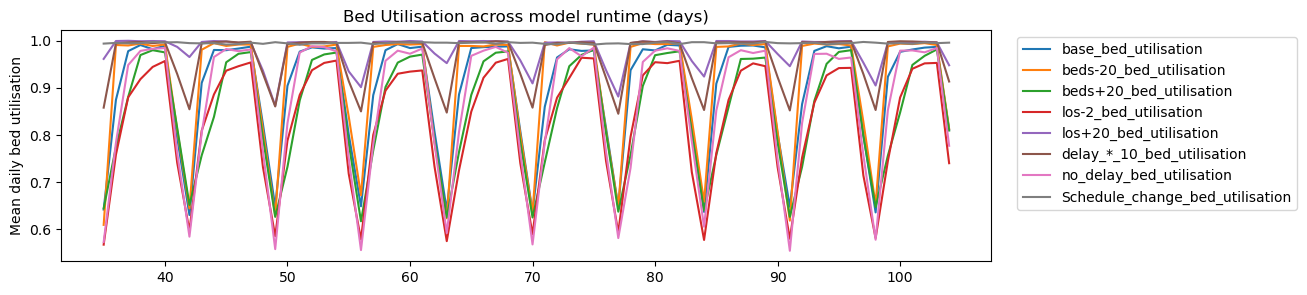

In [8]:
def scenario_daily_audit(scenario_results):
    """
    Daily audit results for each performance measure by scenario
    Takes scenario_results[1] as an input: daily audit outputs
    Outputs: mean bed utilisation per day
    """
    columns = []
    daily_summary = pd.DataFrame()
    
    for sc_name, replications in scenario_results.items():
        daily_summary = pd.concat([daily_summary, replications.groupby(['sim_time']).mean()],
                                    axis=1)
        columns.append(sc_name)
    
    values = daily_summary['bed_utilisation']
    columns = list(map('_'.join, zip(columns, values)))
    values.columns = columns
    
    fig, ax = plt.subplots(figsize=(12,3))
    ax.plot(values)
    ax.set_title('Bed Utilisation across model runtime (days)')
    ax.set_ylabel('Mean daily bed utilisation')
    ax.legend(columns, bbox_to_anchor=(1.02, 1),loc='upper left')
    
    return (daily_summary, fig)
    
scenario_daily_audit(scenario_results[1]);
#plt.savefig('Daily bed utilisation scenarios')

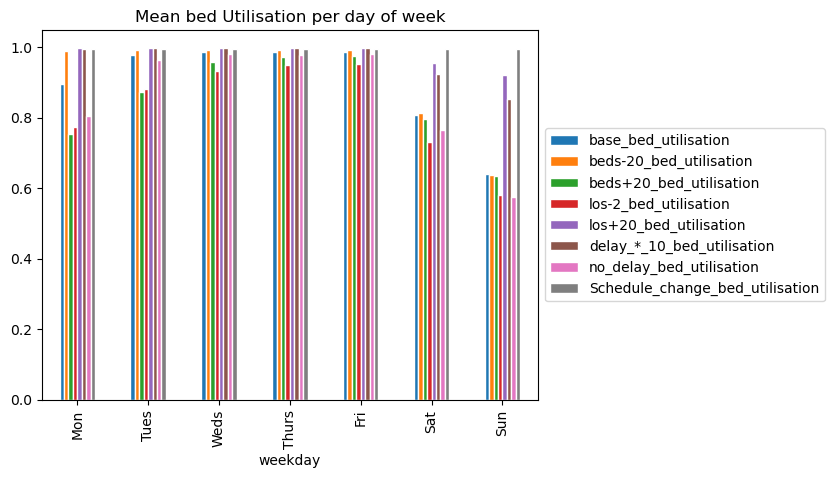

In [9]:
def scenario_weekly_audit(scenario_results):
    """
    Weekly audit results for each performance measure by scenario
    """
    columns = []
    weekly_summary = pd.DataFrame()
    
    for sc_name, replications in scenario_results.items():
        weekly_summary = pd.concat([weekly_summary, replications.groupby(['weekday']).mean()],
                                    axis=1)
        columns.append(sc_name)
        
    values = weekly_summary['bed_utilisation']
    columns = list(map('_'.join, zip(columns, values)))
    values.columns = columns
    day_map = {0: 'Mon', 1: 'Tues', 2: 'Weds', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    values = values.rename(index=day_map)
    values.plot(kind='bar', stacked=False,edgecolor='white',
                title='Mean bed Utilisation per day of week')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    return (plt)    

plot1 = scenario_weekly_audit(scenario_results[1])

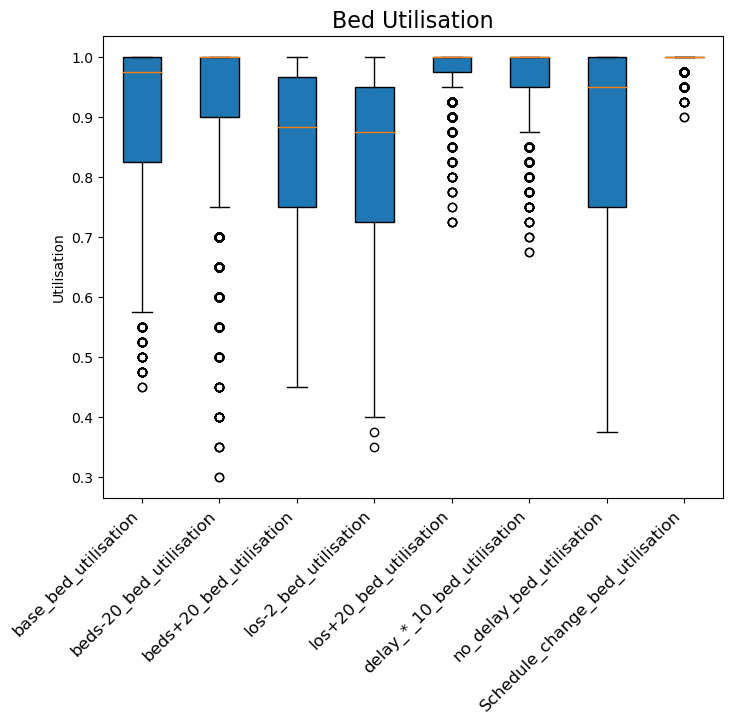

In [10]:
def scenario_weekly_boxplots(scenario_results):
    """
    Audit results for each performance measure by scenario
    """
    columns = []
    weekly_summary = pd.DataFrame()

    for sc_name, replications in scenario_results.items():
            weekly_summary = pd.concat([weekly_summary, replications.groupby(['weekday']).apply(lambda x:x)],
                                axis=1)
            columns.append(sc_name)


    values = weekly_summary['bed_utilisation']
    columns = list(map('_'.join, zip(columns, values)))
    values.columns = columns
    
    fig, ax = plt.subplots(figsize=(8, 6))

    # create the boxplot
    bp = ax.boxplot(values.values, patch_artist=True)
    ax.set_ylabel('Utilisation')

    plt.xticks(range(1, len(values.columns) +1), values.columns)
    ax.set_xticklabels(values.columns, fontsize=12, rotation=45, ha='right')
    ax.set_title('Bed Utilisation', fontsize=16)

plot1 = scenario_weekly_boxplots(scenario_results[1])

In [11]:
def patient_scenarios(scenario_results):
    """
    Takes patient level results for each performance measure by scenario
    Selects lost slots to return lost slots 
    """
    columns = []
    patient_summary = pd.DataFrame()

    for sc_name, replications in scenario_results.items():

        patient_summary = pd.concat([patient_summary, replications.groupby(['Day', 'weekday'])\
                                     ['lost slots'].sum().astype(int)],axis=1) 
        columns.append(sc_name) 
        
    patient_summary = patient_summary.apply(lambda x: x / md.DEFAULT_NUMBER_OF_RUNS)
    columns = list(map('_'.join, zip(columns, patient_summary)))
    patient_summary.columns = columns
    patient_summary = patient_summary.reset_index()
    patient_summary.rename(columns = {'level_0':'Day', 'level_1':'weekday'}, inplace = True)
    
    return(patient_summary)

patient_summary = patient_scenarios(scenario_results_patients)

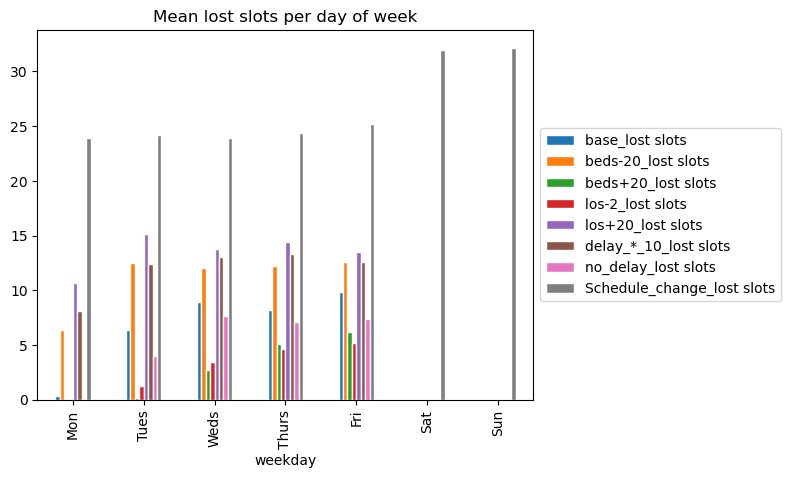

In [12]:
def lost_slots(patient_summary):

    """
    Takes output of previous function patient_scenarios()
    Deals with 0-day arrivals
    plot lost slots per scenario per weekday
    
    """
    patient_summ = (patient_summary.set_index('Day')
        .reindex(range(patient_summary.Day.iat[0],patient_summary.Day.iat[-1]+1), fill_value=0)
        .reset_index())
    shortseq = np.arange(len(range(0,7)))
    length = math.ceil(len(patient_summ) / 7)
        #create total sequence and flatten array list into list of elements
    sequence = ([np.tile((shortseq),length)])
    flat_seq = list(itertools.chain(*sequence))
        #truncate to correct length and save to column
    sequence = flat_seq[:len(patient_summ)]
    patient_summ['weekday'] = sequence 
    patient_summ = patient_summ.fillna(0)
    
    patient_summ = patient_summ[patient_summ["Day"] > md.DEFAULT_WARM_UP_PERIOD]    
    patient_summ = patient_summ.groupby('weekday').mean().reset_index()
    patient_summ = patient_summ.loc[:, patient_summ.columns != 'Day']
    day_map = {0: 'Mon', 1: 'Tues', 2: 'Weds', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    patient_summ['weekday'] = patient_summ['weekday'].map(day_map)
    patient_summ.plot(kind='bar', stacked=False, edgecolor='white', 
                      x='weekday', title='Mean lost slots per day of week')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

    return(plt)

plot2 = lost_slots(patient_summary)

,base_Counts,beds-20_Counts,beds+20_Counts,los-2_Counts,los+20_Counts,delay_*_10_Counts,no_delay_Counts,Schedule_change_Counts,run time (days)
0,456.82,238.24,654.58,640.76,110.74,190.64,525.7,519.88,70


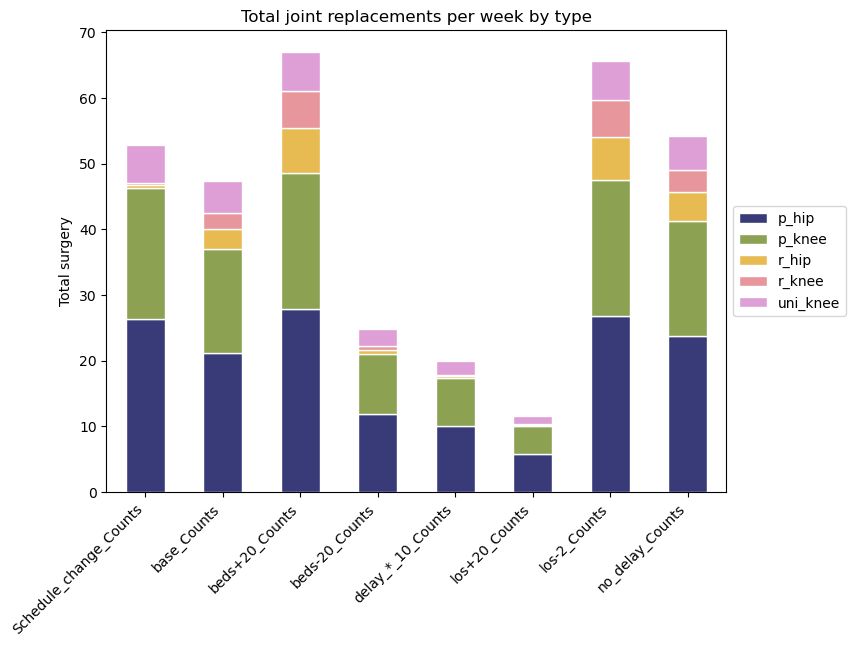

In [13]:
def total_thruput_pt_results(scenario_results): 
    
    """
    Takes patient level results for each performance measure by scenario
    Deal with 0-day arrivals
    Return plot of total thruput stacked by surgery type per scenario
    
    """
    
    columns = []
    patient_summary = pd.DataFrame()

    for sc_name, replications in scenario_results.items():
        
        replications = replications[replications['lost slots'] == False]
        replications = replications[replications['Day'] > md.DEFAULT_WARM_UP_PERIOD]
        replications = replications[['Day','weekday','surgery type', 'depart']]
        
        patient_summary = pd.concat([patient_summary, replications.groupby(['Day','weekday','surgery type'])\
                                     ['surgery type'].count()],axis=1)

        columns.append(sc_name)  

    patient_summary.rename(columns = {'surgery type':'Counts'}, inplace = True)
    patient_summary = patient_summary.assign(Counts = lambda x: (x['Counts'] / md.DEFAULT_NUMBER_OF_RUNS)).fillna(0)
    columns = list(map('_'.join, zip(columns, patient_summary)))
    patient_summary.columns = columns
    patient_summary = patient_summary.reset_index()
    patient_summary.rename(columns = {'level_0':'Day', 'level_1':'weekday', 'level_2':'surgery type'}, inplace = True)
    patient_summary = pd.DataFrame(patient_summary.groupby(['weekday','surgery type'])[columns].mean())
    
    patient_summary = patient_summary.reset_index()
    day_map = {0: 'Mon', 1: 'Tues', 2: 'Weds', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    
    values=patient_summary.filter(regex='_Counts')
    melted_df = pd.melt(patient_summary, id_vars=['weekday', 'surgery type'], value_vars=list(values), 
                        var_name='_Counts', value_name='Counts')

    # plot the stacked bar chart
    fig, ax = plt.subplots(figsize=(8, 6))
    melted_df.groupby(['_Counts', 'surgery type']).sum()['Counts'].unstack().plot(kind='bar', 
                                    stacked=True, ax=ax, colormap='tab20b', edgecolor='white')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.ylabel('Total surgery')
    plt.xlabel('')
    plt.title('Total joint replacements per week by type')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    
    return plt

def total_thruput_table(scenario_results):
    
    """
    Takes patient level results for each performance measure by scenario
    Removes lost slots (never had surgery)
    Returns table of total throuput across run-time
    (Add run time value)
    """
    
    columns = []
    patient_summary = pd.DataFrame()

    for sc_name, replications in scenario_results.items():
        
        replications = replications[replications['lost slots'] == False]
        replications = replications[replications['Day'] > md.DEFAULT_WARM_UP_PERIOD]
        replications = replications[['Day','weekday', 'lost slots']]
        
        patient_summary = pd.concat([patient_summary, replications.groupby(['Day','weekday'])\
                                     ['lost slots'].count()],axis=1) 

        columns.append(sc_name)
        
    patient_summary.rename(columns = {'lost slots':'Counts'}, inplace = True)
    patient_summary = patient_summary.assign(Counts = lambda x: (x['Counts'] / md.DEFAULT_NUMBER_OF_RUNS)).fillna(0)
    columns = list(map('_'.join, zip(columns, patient_summary)))
    patient_summary.columns = columns
    patient_summary = patient_summary.reset_index()
    patient_summary = patient_summary.drop(['level_0', 'level_1'], axis=1)
    values=patient_summary.filter(regex='_Counts')
    patient_summary = pd.DataFrame(patient_summary.sum(axis=0)).T
    patient_summary['run time (days)'] = md.DEFAULT_RESULTS_COLLECTION_PERIOD

    return patient_summary

    ######################################

thruput = total_thruput_pt_results(scenario_results_patients)
#plt.savefig('thruput_lnorm')
table = total_thruput_table(scenario_results_patients)
table

## 2. MODEL TEST RUNS: Changing bed parameters

In [14]:
def get_scenarios_beds():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Used for testing change in number of beds, all else stays the same
    
    Returns:
    --------
    dict
        Contains stress tests for the model
    '''
    scenarios = {}
    schedule = md.Schedule()
    #scenarios['base'] = Scenario(schedule)
    
    # define scenarios
    for n_beds in range(20, 85, 5):
        key = f'beds{n_beds:_}'  # Create a key for each scenario
        scenarios[key] = md.Scenario(schedule, n_beds=n_beds)
   
    return scenarios


def run_scenario_analysis_beds(scenarios, rc_period, n_reps):
    '''
    Run each of the scenarios for a specified results
    collection period and replications.
    
    Returns:
    a) summary results table
    b) Results per day
    c) Patient-level results
       
    Params:
    ------
    scenarios: dict
        dictionary of Scenario objects
        
    rc_period: float
        model run length
        
    n_rep: int
        Number of replications
    
    '''
    print('Scenario Analysis')
    print(f'No. Scenario: {len(scenarios)}')
    print(f'Replications: {n_reps}')

    scenario_results_summ = {}
    scenario_results_day = {}
    scenario_results_ppat = {}
    scenario_results_rpat = {}
    
    for sc_name, scenario in scenarios.items():
        
        print(f'Running {sc_name}', end=' => ')
        
        replications = md.multiple_reps(scenario, results_collection=md.DEFAULT_RESULTS_COLLECTION_PERIOD+md.DEFAULT_WARM_UP_PERIOD, 
                                     n_reps=md.DEFAULT_NUMBER_OF_RUNS)
        
        replications_summ = replications[0]
        replications_day = replications[1]
        replications_ppat = replications[2]
        replications_rpat = replications[3]
        
                    
        print('done.\n')
        
        #save the results
        scenario_results_summ[sc_name] = replications_summ
        scenario_results_day[sc_name] = replications_day
        scenario_results_ppat[sc_name] = replications_ppat
        scenario_results_rpat[sc_name] = replications_rpat
    
         
    print('Scenario analysis complete.')
    return (scenario_results_summ, scenario_results_day,scenario_results_ppat,scenario_results_rpat)

#script to run scenario analysis
#get the scenarios
scenarios = get_scenarios_beds()

#run the scenario analysis for summary results
scenario_results_beds = run_scenario_analysis_beds(scenarios, 
                                         md.DEFAULT_RESULTS_COLLECTION_PERIOD+md.DEFAULT_WARM_UP_PERIOD,
                                         n_reps= md.DEFAULT_NUMBER_OF_RUNS)#number_of_runs

scenario_results_patients_beds = {key: pd.concat([scenario_results_beds[2][key], scenario_results_beds[3][key]], 
                              ignore_index=True) for key in scenario_results_beds[2].keys()}



Scenario Analysis
No. Scenario: 13
Replications: 50
Running beds20 => done.

Running beds25 => done.

Running beds30 => done.

Running beds35 => done.

Running beds40 => done.

Running beds45 => done.

Running beds50 => done.

Running beds55 => done.

Running beds60 => done.

Running beds65 => done.

Running beds70 => done.

Running beds75 => done.

Running beds80 => done.

Scenario analysis complete.


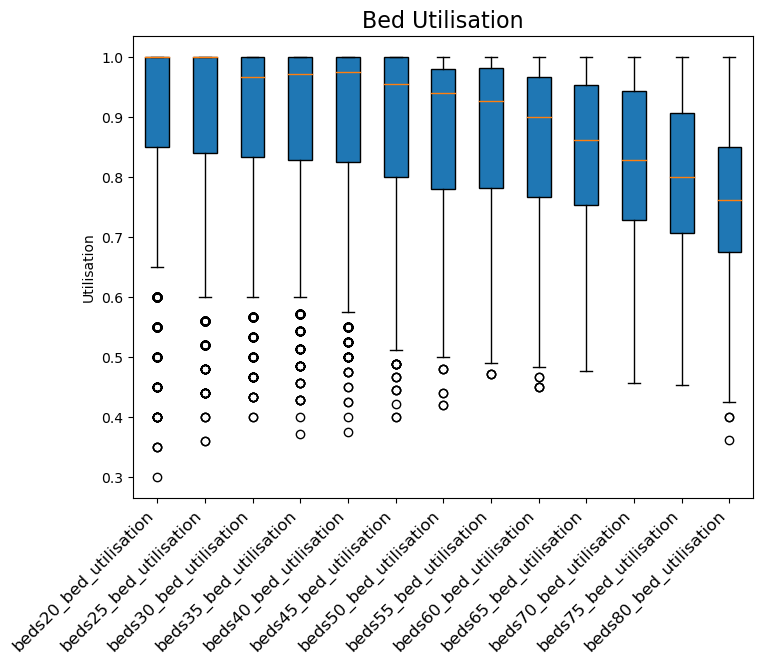

In [15]:
scenario_weekly_boxplots(scenario_results_beds[1])

,beds20_Counts,beds25_Counts,beds30_Counts,beds35_Counts,beds40_Counts,beds45_Counts,beds50_Counts,beds55_Counts,beds60_Counts,beds65_Counts,beds70_Counts,beds75_Counts,beds80_Counts,run time (days)
0,239.2,293.36,345.42,400.92,453.62,512.08,558.32,604.5,652.28,701.38,727.34,764.1,785.46,70


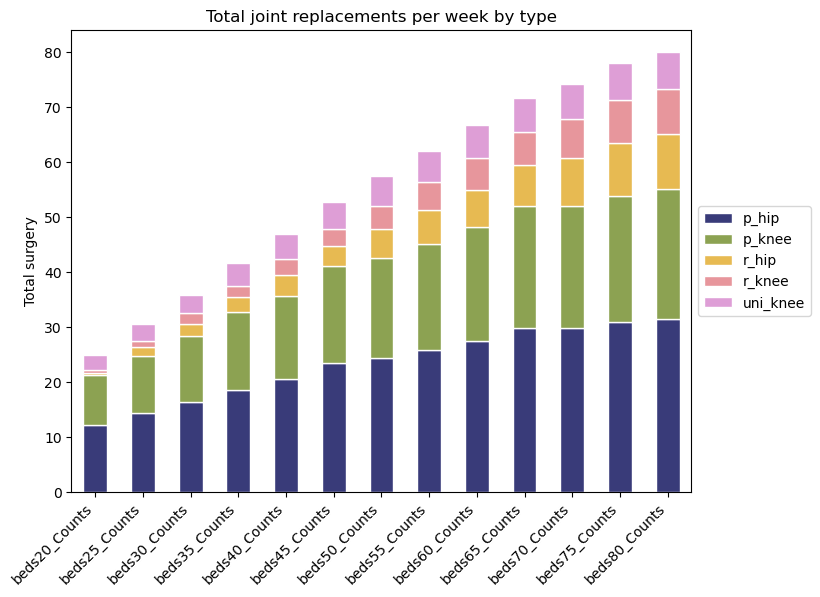

In [16]:
thruput_beds = total_thruput_pt_results(scenario_results_patients_beds)
table = total_thruput_table(scenario_results_patients_beds)
table

<module 'matplotlib.pyplot' from '/home/alison/anaconda3/envs/hep_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

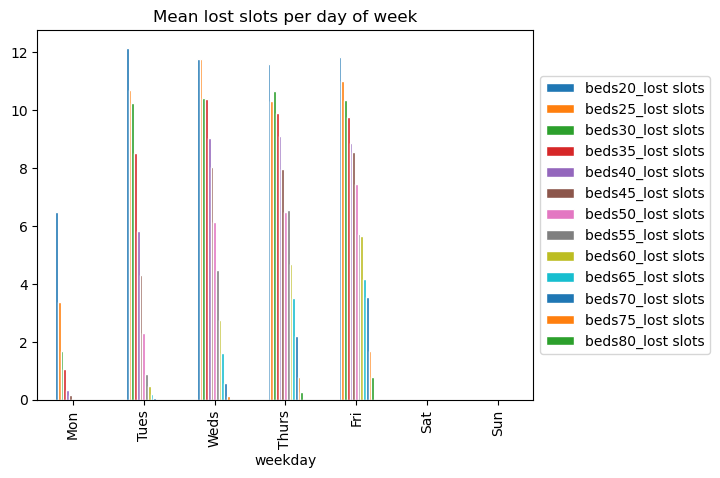

In [17]:
patient_summary_beds = patient_scenarios(scenario_results_patients_beds)
lost_slots(patient_summary_beds)
#plt.savefig('Lost slots beds')

## 3. MODEL TEST RUNS: Variance on LoS of revision patients

In [30]:
def get_scenarios_variance():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Used for testing change in sd for revision hips and knees
    
    Returns:
    --------
    dict
        Contains stress tests for the model
    '''
    scenarios = {}
    schedule = md.Schedule()
    #scenarios['base'] = Scenario(schedule)
    
    # define scenarios       
    for revision_hip_sd_los, revision_knee_sd_los in zip(range(2, 12, 1), range(2, 12, 1)):
        key = f'hip{revision_hip_sd_los:.1f}_knee{revision_knee_sd_los:.1f}'  # Create a key for each scenario
        scenarios[key] = md.Scenario(schedule, n_beds = 75, revision_hip_sd_los=revision_hip_sd_los, revision_knee_sd_los=revision_knee_sd_los)

    return scenarios


def run_scenario_analysis_variance(scenarios, rc_period, n_reps):
    '''
    Run each of the scenarios for a specified results
    collection period and replications.
    
    Returns:
    a) summary results table
    b) Results per day
    c) Patient-level results
       
    Params:
    ------
    scenarios: dict
        dictionary of Scenario objects
        
    rc_period: float
        model run length
        
    n_rep: int
        Number of replications
    
    '''
    print('Scenario Analysis')
    print(f'No. Scenario: {len(scenarios)}')
    print(f'Replications: {n_reps}')

    scenario_results_summ = {}
    scenario_results_day = {}
    scenario_results_ppat = {}
    scenario_results_rpat = {}
    
    for sc_name, scenario in scenarios.items():
        
        print(f'Running {sc_name}', end=' => ')
        
        replications = md.multiple_reps(scenario, results_collection=md.DEFAULT_RESULTS_COLLECTION_PERIOD+md.DEFAULT_WARM_UP_PERIOD, 
                                     n_reps=md.DEFAULT_NUMBER_OF_RUNS)
        
        replications_summ = replications[0]
        replications_day = replications[1]
        replications_ppat = replications[2]
        replications_rpat = replications[3]
        
                    
        print('done.\n')
        
        #save the results
        scenario_results_summ[sc_name] = replications_summ
        scenario_results_day[sc_name] = replications_day
        scenario_results_ppat[sc_name] = replications_ppat
        scenario_results_rpat[sc_name] = replications_rpat
    
         
    print('Scenario analysis complete.')
    return (scenario_results_summ, scenario_results_day,scenario_results_ppat,scenario_results_rpat)

#script to run scenario analysis
#get the scenarios
scenarios = get_scenarios_variance()

#run the scenario analysis for summary results
scenario_results_variance = run_scenario_analysis_variance(scenarios, 
                                         md.DEFAULT_RESULTS_COLLECTION_PERIOD+md.DEFAULT_WARM_UP_PERIOD,
                                         n_reps= md.DEFAULT_NUMBER_OF_RUNS)#number_of_runs

scenario_results_patients_variance = {key: pd.concat([scenario_results_variance[2][key], scenario_results_variance[3][key]], 
                              ignore_index=True) for key in scenario_results_variance[2].keys()}



Scenario Analysis
No. Scenario: 10
Replications: 50
Running hip2.0_knee2.0 => done.

Running hip3.0_knee3.0 => done.

Running hip4.0_knee4.0 => done.

Running hip5.0_knee5.0 => done.

Running hip6.0_knee6.0 => done.

Running hip7.0_knee7.0 => done.

Running hip8.0_knee8.0 => done.

Running hip9.0_knee9.0 => done.

Running hip10.0_knee10.0 => done.

Running hip11.0_knee11.0 => done.

Scenario analysis complete.


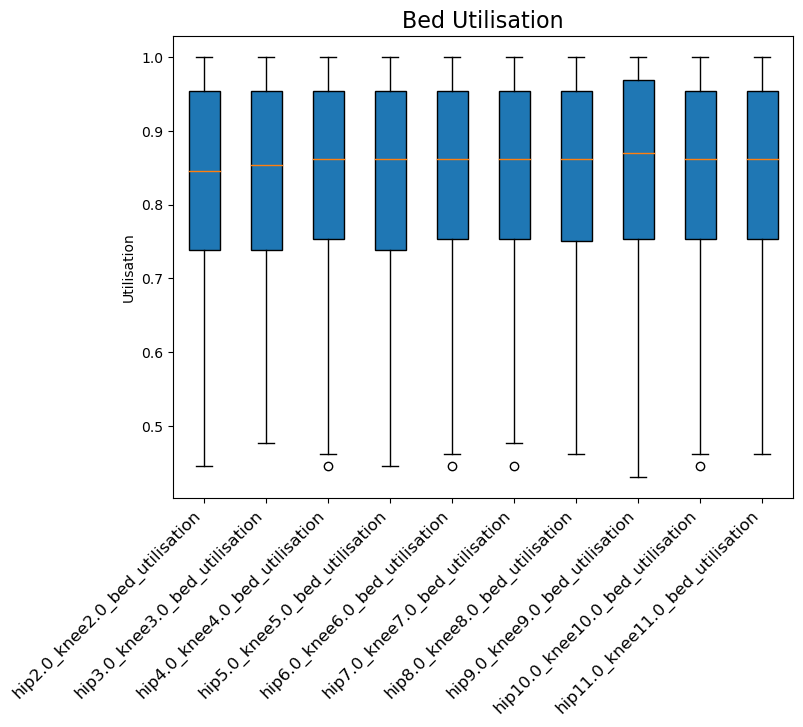

In [19]:
scenario_weekly_boxplots(scenario_results_variance[1])

,hip2.0_knee2.0_Counts,hip3.0_knee3.0_Counts,hip4.0_knee4.0_Counts,hip5.0_knee5.0_Counts,hip6.0_knee6.0_Counts,hip7.0_knee7.0_Counts,hip8.0_knee8.0_Counts,hip9.0_knee9.0_Counts,hip10.0_knee10.0_Counts,hip11.0_knee11.0_Counts,run time (days)
0,706.22,697.3,702.86,695.52,700.08,691.16,691.86,707.68,699.16,702.04,70


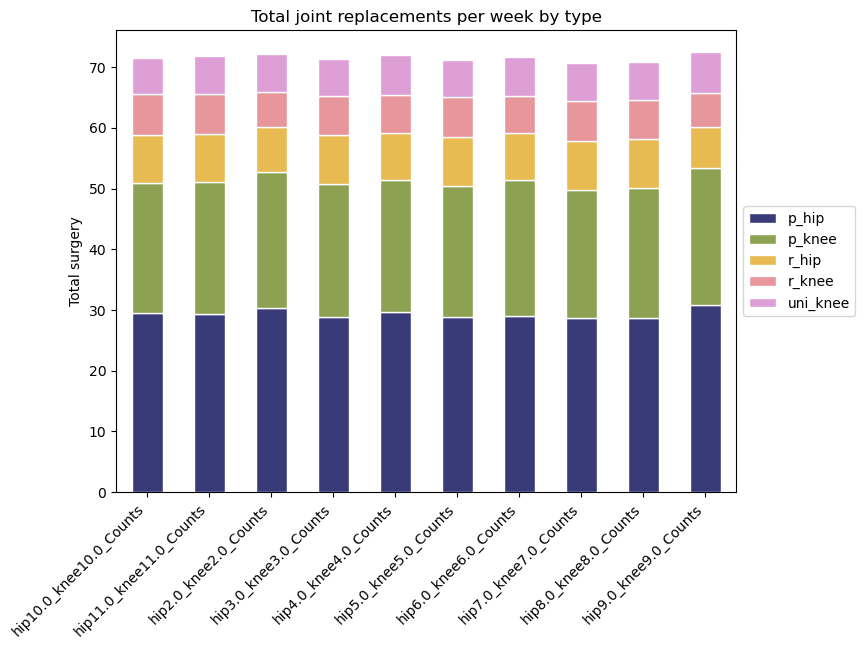

In [20]:
thruput_variance = total_thruput_pt_results(scenario_results_patients_variance)
table = total_thruput_table(scenario_results_patients_variance)
table

<module 'matplotlib.pyplot' from '/home/alison/anaconda3/envs/hep_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

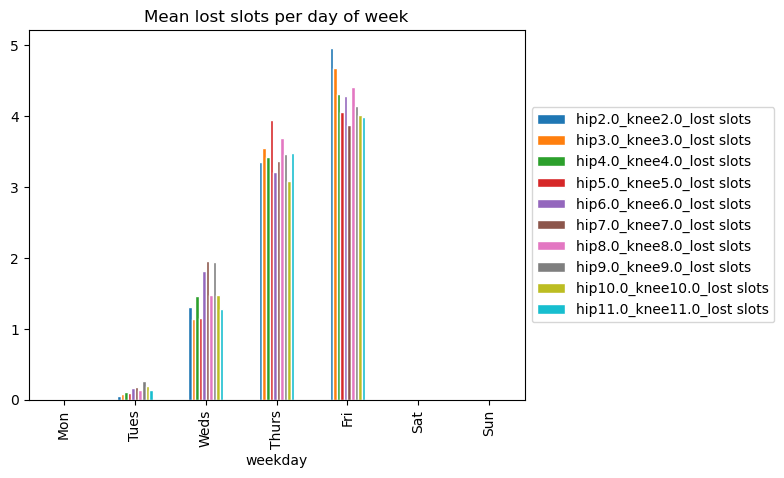

In [21]:
patient_summary_variance = patient_scenarios(scenario_results_patients_variance)
lost_slots(patient_summary_variance)

## 4. MODEL TEST RUNS: Changing Revision LoS

In [22]:
def get_scenarios_revision_los():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Used for testing change in sd for revision hips and knees
    
    Returns:
    --------
    dict
        Contains stress tests for the model
    '''
    scenarios = {}
    schedule = md.Schedule()
    #scenarios['base'] = Scenario(schedule)
    
    # define scenarios       
    for revision_hip_mean_los, revision_knee_mean_los in zip(range(1, 8, 1), range(1, 8, 1)):
        key = f'hip{revision_hip_mean_los:.1f}_knee{revision_knee_mean_los:.1f}'  # Create a key for each scenario
        scenarios[key] = md.Scenario(schedule, n_beds = 40, revision_hip_mean_los=revision_hip_mean_los, revision_knee_mean_los=revision_knee_mean_los)

    return scenarios


def run_scenario_analysis_revision_los(scenarios, rc_period, n_reps):
    '''
    Run each of the scenarios for a specified results
    collection period and replications.
    
    Returns:
    a) summary results table
    b) Results per day
    c) Patient-level results
       
    Params:
    ------
    scenarios: dict
        dictionary of Scenario objects
        
    rc_period: float
        model run length
        
    n_rep: int
        Number of replications
    
    '''
    print('Scenario Analysis')
    print(f'No. Scenario: {len(scenarios)}')
    print(f'Replications: {n_reps}')

    scenario_results_summ = {}
    scenario_results_day = {}
    scenario_results_ppat = {}
    scenario_results_rpat = {}
    
    for sc_name, scenario in scenarios.items():
        
        print(f'Running {sc_name}', end=' => ')
        
        replications = md.multiple_reps(scenario, results_collection=md.DEFAULT_RESULTS_COLLECTION_PERIOD+md.DEFAULT_WARM_UP_PERIOD, 
                                     n_reps=md.DEFAULT_NUMBER_OF_RUNS)
        
        replications_summ = replications[0]
        replications_day = replications[1]
        replications_ppat = replications[2]
        replications_rpat = replications[3]
        
                    
        print('done.\n')
        
        #save the results
        scenario_results_summ[sc_name] = replications_summ
        scenario_results_day[sc_name] = replications_day
        scenario_results_ppat[sc_name] = replications_ppat
        scenario_results_rpat[sc_name] = replications_rpat
    
         
    print('Scenario analysis complete.')
    return (scenario_results_summ, scenario_results_day,scenario_results_ppat,scenario_results_rpat)

#script to run scenario analysis
#get the scenarios
scenarios = get_scenarios_revision_los()

#run the scenario analysis for summary results
scenario_results_revision_los = run_scenario_analysis_revision_los(scenarios, 
                                         md.DEFAULT_RESULTS_COLLECTION_PERIOD+md.DEFAULT_WARM_UP_PERIOD,
                                         n_reps= md.DEFAULT_NUMBER_OF_RUNS)#number_of_runs

scenario_results_patients_revision_los = {key: pd.concat([scenario_results_revision_los[2][key], scenario_results_revision_los[3][key]], 
                              ignore_index=True) for key in scenario_results_revision_los[2].keys()}



Scenario Analysis
No. Scenario: 7
Replications: 50
Running hip1.0_knee1.0 => done.

Running hip2.0_knee2.0 => done.

Running hip3.0_knee3.0 => done.

Running hip4.0_knee4.0 => done.

Running hip5.0_knee5.0 => done.

Running hip6.0_knee6.0 => done.

Running hip7.0_knee7.0 => done.

Scenario analysis complete.


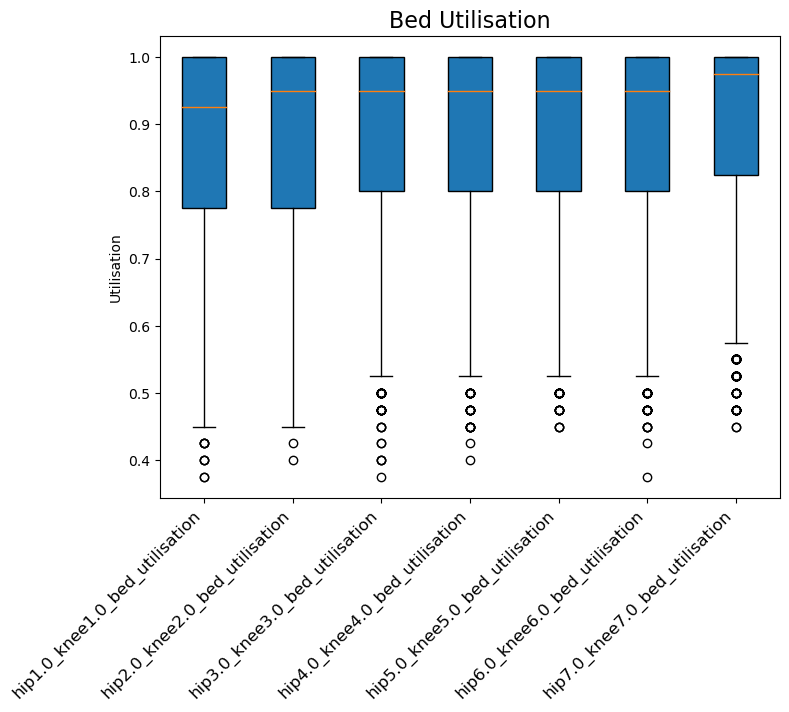

In [34]:
scenario_weekly_boxplots(scenario_results_revision_los[1])

,hip1.0_knee1.0_Counts,hip2.0_knee2.0_Counts,hip3.0_knee3.0_Counts,hip4.0_knee4.0_Counts,hip5.0_knee5.0_Counts,hip6.0_knee6.0_Counts,hip7.0_knee7.0_Counts,run time (days)
0,522.56,519.78,502.16,486.78,476.6,466.06,464.54,70


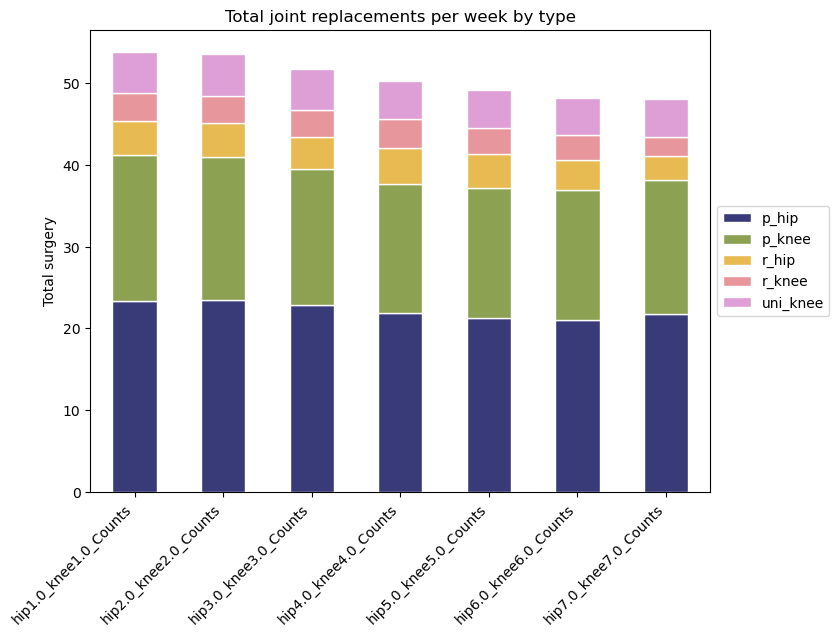

In [35]:
thruput_revision_los = total_thruput_pt_results(scenario_results_patients_revision_los)
table = total_thruput_table(scenario_results_patients_revision_los)
table

<module 'matplotlib.pyplot' from '/home/alison/anaconda3/envs/hep_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

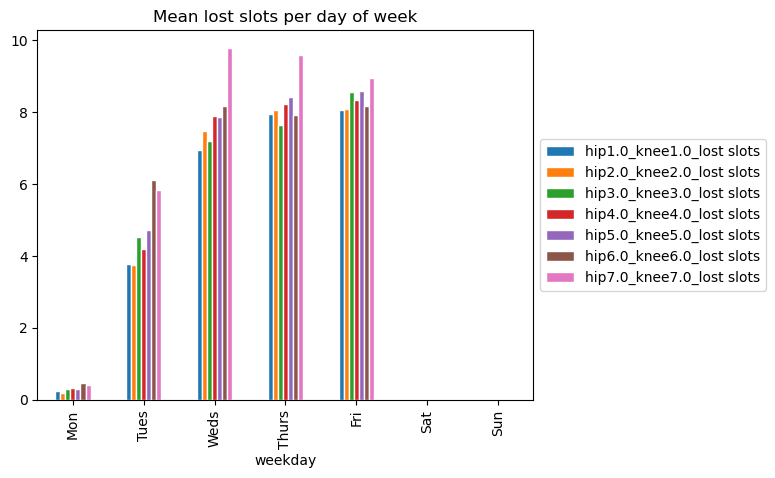

In [36]:
patient_summary_revision_los = patient_scenarios(scenario_results_patients_revision_los)
lost_slots(patient_summary_revision_los)

## 5. MODEL TEST RUNS: Changing all LoS

In [37]:
def get_scenarios_all_los():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Used for testing change in sd for revision hips and knees
    
    Returns:
    --------
    dict
        Contains stress tests for the model
    '''
    scenarios = {}
    schedule = md.Schedule()
    #scenarios['base'] = Scenario(schedule)
    
    # define scenarios       
    for revision_hip_mean_los, revision_knee_mean_los, primary_hip_mean_los,primary_knee_mean_los, unicompart_knee_mean_los in zip(range(3, 8, 1), 
                                                           range(3, 8, 1), range(1, 6, 1), 
                                                           range(1, 6, 1), range(1, 6, 1)):
        key = f'r-THR{revision_hip_mean_los:.1f}_r-TKR{revision_knee_mean_los:.1f}_p-THR{primary_hip_mean_los:.1f}_p-TKR{primary_knee_mean_los:.1f}_p-UKR{unicompart_knee_mean_los:.1f}'  # Create a key for each scenario
        scenarios[key] = md.Scenario(schedule, revision_hip_mean_los=revision_hip_mean_los, revision_knee_mean_los=revision_knee_mean_los,
                                     primary_hip_mean_los = primary_hip_mean_los, primary_knee_mean_los=primary_knee_mean_los, 
                                     unicompart_knee_mean_los=unicompart_knee_mean_los, n_beds = 65)

    return scenarios


def run_scenario_analysis_all_los(scenarios, rc_period, n_reps):
    '''
    Run each of the scenarios for a specified results
    collection period and replications.
    
    Returns:
    a) summary results table
    b) Results per day
    c) Patient-level results
       
    Params:
    ------
    scenarios: dict
        dictionary of Scenario objects
        
    rc_period: float
        model run length
        
    n_rep: int
        Number of replications
    
    '''
    print('Scenario Analysis')
    print(f'No. Scenario: {len(scenarios)}')
    print(f'Replications: {n_reps}')

    scenario_results_summ = {}
    scenario_results_day = {}
    scenario_results_ppat = {}
    scenario_results_rpat = {}
    
    for sc_name, scenario in scenarios.items():
        
        print(f'Running {sc_name}', end=' => ')
        
        replications = md.multiple_reps(scenario, results_collection=md.DEFAULT_RESULTS_COLLECTION_PERIOD+md.DEFAULT_WARM_UP_PERIOD, 
                                     n_reps=md.DEFAULT_NUMBER_OF_RUNS)
        
        replications_summ = replications[0]
        replications_day = replications[1]
        replications_ppat = replications[2]
        replications_rpat = replications[3]
        
                    
        print('done.\n')
        
        #save the results
        scenario_results_summ[sc_name] = replications_summ
        scenario_results_day[sc_name] = replications_day
        scenario_results_ppat[sc_name] = replications_ppat
        scenario_results_rpat[sc_name] = replications_rpat
    
         
    print('Scenario analysis complete.')
    return (scenario_results_summ, scenario_results_day,scenario_results_ppat,scenario_results_rpat)

#script to run scenario analysis
#get the scenarios
scenarios = get_scenarios_all_los()

#run the scenario analysis for summary results
scenario_results_all_los = run_scenario_analysis_all_los(scenarios, 
                                         md.DEFAULT_RESULTS_COLLECTION_PERIOD+md.DEFAULT_WARM_UP_PERIOD,
                                         n_reps= md.DEFAULT_NUMBER_OF_RUNS)#number_of_runs

scenario_results_patients_all_los = {key: pd.concat([scenario_results_all_los[2][key], scenario_results_all_los[3][key]], 
                              ignore_index=True) for key in scenario_results_all_los[2].keys()}



Scenario Analysis
No. Scenario: 5
Replications: 50
Running r-THR3.0_r-TKR3.0_p-THR1.0_p-TKR1.0_p-UKR1.0 => done.

Running r-THR4.0_r-TKR4.0_p-THR2.0_p-TKR2.0_p-UKR2.0 => done.

Running r-THR5.0_r-TKR5.0_p-THR3.0_p-TKR3.0_p-UKR3.0 => done.

Running r-THR6.0_r-TKR6.0_p-THR4.0_p-TKR4.0_p-UKR4.0 => done.

Running r-THR7.0_r-TKR7.0_p-THR5.0_p-TKR5.0_p-UKR5.0 => done.

Scenario analysis complete.


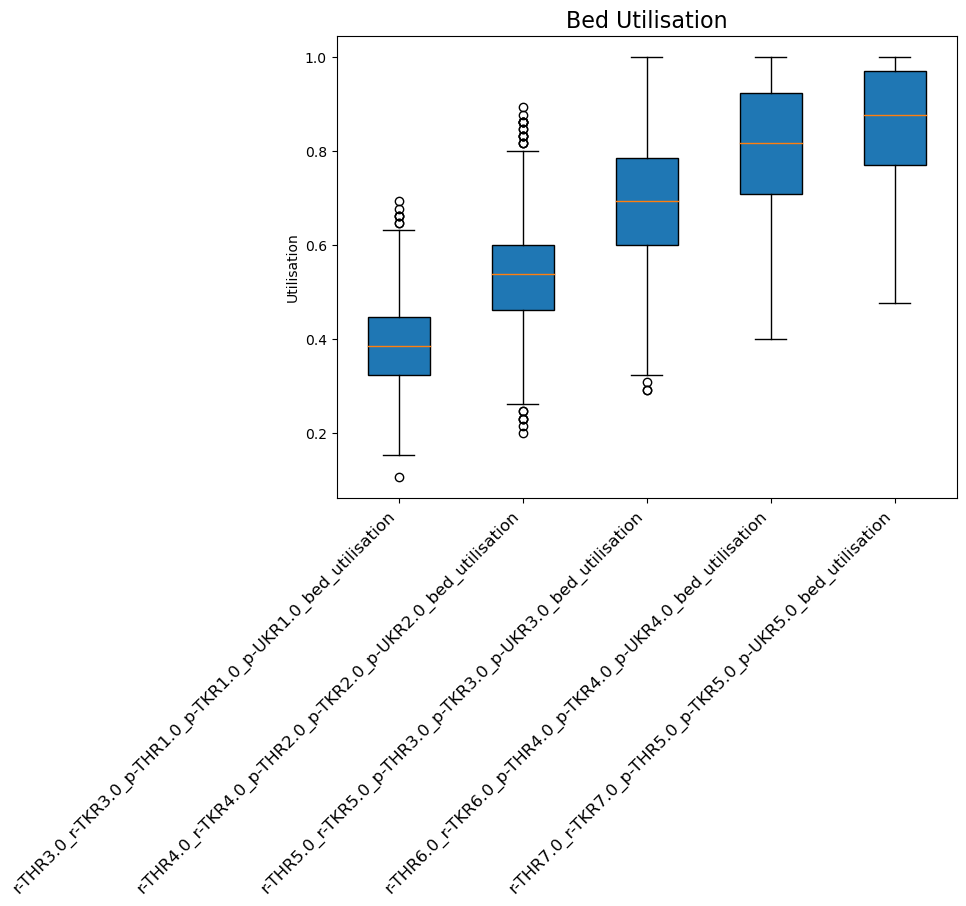

In [38]:
scenario_weekly_boxplots(scenario_results_all_los[1])

,r-THR3.0_r-TKR3.0_p-THR1.0_p-TKR1.0_p-UKR1.0_Counts,r-THR4.0_r-TKR4.0_p-THR2.0_p-TKR2.0_p-UKR2.0_Counts,r-THR5.0_r-TKR5.0_p-THR3.0_p-TKR3.0_p-UKR3.0_Counts,r-THR6.0_r-TKR6.0_p-THR4.0_p-TKR4.0_p-UKR4.0_Counts,r-THR7.0_r-TKR7.0_p-THR5.0_p-TKR5.0_p-UKR5.0_Counts,run time (days)
0,772.0,774.0,766.12,733.52,650.98,70


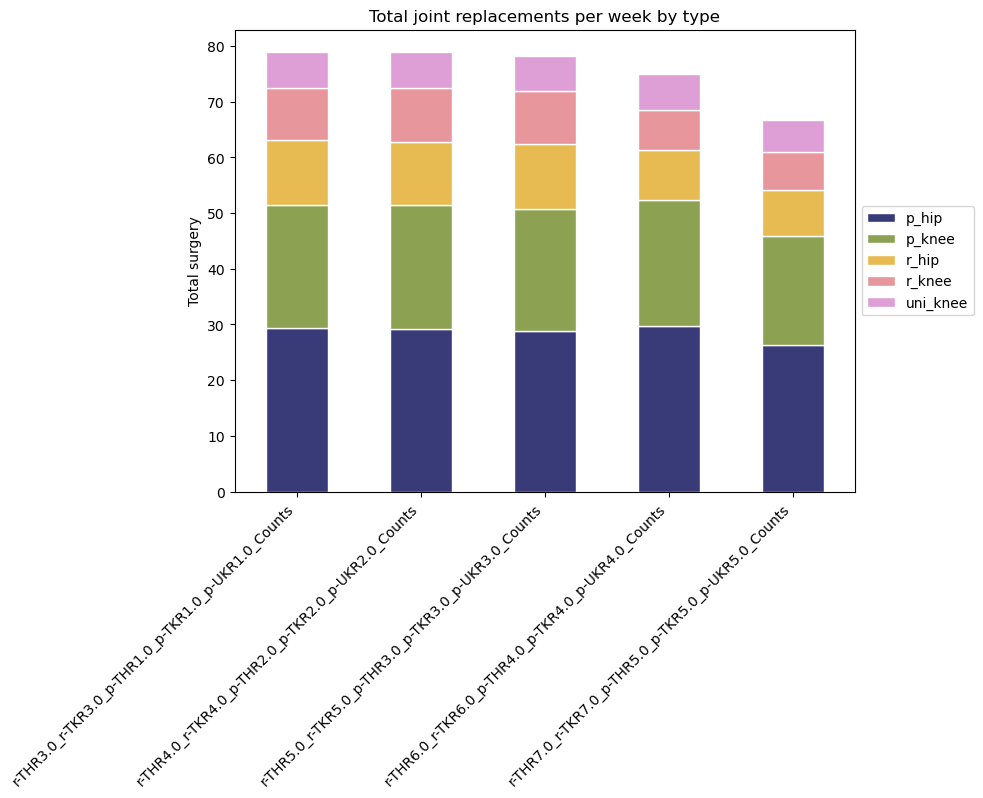

In [39]:
thruput_all_los = total_thruput_pt_results(scenario_results_patients_all_los)
table = total_thruput_table(scenario_results_patients_all_los)
table

<module 'matplotlib.pyplot' from '/home/alison/anaconda3/envs/hep_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

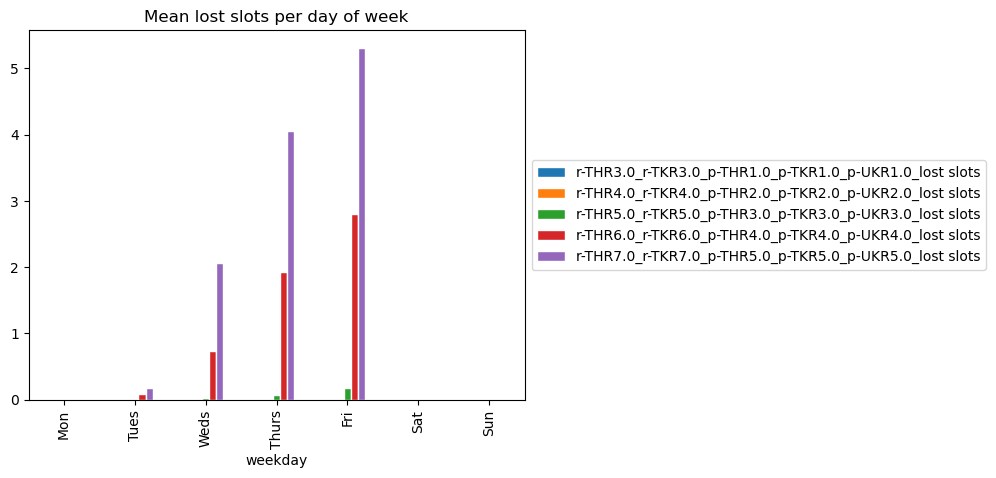

In [40]:
patient_summary_all_los = patient_scenarios(scenario_results_patients_all_los)
lost_slots(patient_summary_all_los)